In [1]:
# Deep learning framework
import keras
print(keras.__version__)
# Implements TensorFlow on GPU (hence older version)
import tensorflow as tf
print(tf.__version__)
# Data importing
import pandas as pd
print(pd.__version__)
# Matrix and numerical functions
import numpy as np
print(np.__version__)
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Serializing objects
import pickle
# Serializing trained models
import h5py
# Printing readable results
from prettytable import PrettyTable

# Various Keras tools
from keras.models import Model, Sequential, model_from_json
from keras import layers, regularizers, Input, Model, callbacks
from keras.optimizers import RMSprop, Adam, Nadam
from keras.utils import plot_model
# Have to use K.clear_session() for TensorBoard to work
from keras import backend as K

Using TensorFlow backend.


2.1.3
1.1.0
0.22.0
1.12.1


#### Generator function to prepare (windowed) batches of two input datasets and an output.
* `market`, `grib`, `vwp`: The Numpy arrays of market, grib, and VWP price data.
* `lookback`: How many timesteps back should our input data go.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `Step` and `delay` is never different from 1 and 0 respectively, so are removed from the function.

In [2]:
from functions import multi_generator

#### Pretty plotting

In [3]:
# Use seaborn graphical settings, which are much prettier
sns.set()
# Scale widths, fonts, etc. to fit well in a paper (an alternative would be "notebook")
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

### Load market data

In [4]:
market_train = np.loadtxt('data/standardized_train.csv', delimiter = ',', skiprows = 1)
market_valid = np.loadtxt('data/standardized_valid.csv', delimiter = ',', skiprows = 1)
market_test = np.loadtxt('data/standardized_test.csv', delimiter = ',', skiprows = 1)

In [5]:
stdev = pickle.load(open('data/stdevs', 'rb'))[0]
mean = pickle.load(open('data/means', 'rb'))[0]
headers = pickle.load(open('data/headers', 'rb'))

print(stdev)
print(mean)

13.071125727
32.8342900502


### Load GRIB weather forecasts

In [6]:
grib_train = headers = pickle.load(open('grib_data/x_scaled_train', 'rb'))
grib_valid = headers = pickle.load(open('grib_data/x_scaled_valid', 'rb'))
grib_test = headers = pickle.load(open('grib_data/x_scaled_test', 'rb'))

### Load VWP output values

In [7]:
vwp_train = pickle.load(open('grib_data/y_standardized_train', 'rb'))
vwp_valid = pickle.load(open('grib_data/y_standardized_valid', 'rb'))
vwp_test = pickle.load(open('grib_data/y_standardized_test', 'rb'))

#### Check consistency and drop output value from input datasets (since loaded as separate arrays).

In [8]:
# Ensure that the data is indeed consistent
assert market_train.shape[0] == grib_train.shape[0]
assert market_valid.shape[0] == grib_valid.shape[0]
assert market_test.shape[0] == grib_test.shape[0]

# Ensure that outputs are consistent between the three sets
assert np.sum(vwp_train == market_train[:, 0]) == vwp_train.shape
assert np.sum(vwp_valid == market_valid[:, 0]) == vwp_valid.shape
assert np.sum(vwp_test == market_test[:, 0]) == vwp_test.shape

In [9]:
# Drop the output variable from the input market dataset
market_train = market_train[:, 1:]
market_valid = market_valid[:, 1:]
market_test = market_test[:, 1:]

headers = headers[1:]

In [10]:
train_size = market_train.shape[0]
valid_size = market_valid.shape[0]
test_size = market_test.shape[0]

## Function to evaluate an architecture
Parameters (in order):
- Function to generate models
- Input layer tensor object
- k number of models to generate and evaluate
- Number of epochs
- ce_k number of checkpoints to use for checkpoint ensembling
- Plotting y axis limits (low, high) --> from experimentation
- Folder path to store objects of the models. Numbered sub-folders must alreday exist.
- Training set generator and number of steps
- Validation (test) set generator and numbers of steps
- Vector of variable standard deviations (from when the training set was standardized)

Returns:
- The k trained models
- The corresponding k training histories
- Lists of the MAEs, RMSEs, and Checkpoint Ensembled MAEs and RMSEs for each model

In [11]:
def load_model(model_function, input_market, input_grib, sorted_epoch_num, path, modelnum):
    if(sorted_epoch_num < 10):
        epoch = '0'+str(sorted_epoch_num)
    else:
        epoch = str(sorted_epoch_num)
    
    loaded_model = model_function(input_market, input_grib)
    loaded_model.load_weights(path+modelnum+'/weights_'+epoch+'.h5')
    return loaded_model

def evaluate_mlp(model_function, input_market, input_grib, train_gen, train_steps, stdev, val_gen, val_steps,
                 test_gen, test_steps, path, k = 5, epochs = 30, ce_k = 5, ylim = (2, 5.0)):
    models = []
    histories = []
    val_maes = []
    val_rmses = []
    val_ce_maes = []
    val_ce_rmses = []
    val_ranked_epochs = []
    test_ce_maes = []
    test_ce_rmses = []
    
    
    for i in range(k):
        print('\nTraining model #', str(i+1))
        model = model_function(input_market, input_grib)
        model.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath = path+str(i+1)+'/weights_{epoch:02d}.h5',
                monitor = 'val_loss', mode = 'min', save_weights_only = True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor = 'loss', factor = 0.5, patience = 3, verbose = 1
            )
        ]

        history = model.fit_generator(train_gen, 
                                      steps_per_epoch=train_steps, 
                                      epochs=epochs, 
                                      validation_data=val_gen, 
                                      validation_steps=val_steps,
                                      verbose = 1,
                                      callbacks = callbacks)
        models.append(model)
        histories.append(history)
        
        print('Saving model topology and training history plots.')
        plot_model(model, show_shapes = True, to_file = path+str(i+1)+'/topology.pdf')
        with open(path+str(i+1)+'/model.json', 'w') as json_file:
            json_file.write(model.to_json())
            
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        rmse = np.sqrt(history.history['mean_squared_error'])
        val_rmse = np.sqrt(history.history['val_mean_squared_error'])
        
        sorted_epochs = np.add(np.argsort(val_loss), 1)
        val_ranked_epochs.append(sorted_epochs)
        pickle.dump(sorted_epochs, open(path+str(i+1)+'/sorted_epochs', 'wb'))

        plt.figure()
        plt.plot(range(len(loss)), np.multiply(loss, stdev), 'b', color = 'grey', label='Training loss')
        plt.plot(range(len(loss)), np.multiply(val_loss, stdev), 'b', color = 'blue', label='Validation loss')
        plt.ylim(ylim)
        plt.xlabel('Epoch')
        plt.ylabel('MAE (€)')
        plt.legend(frameon = True, framealpha = 1)
        plt.savefig(path+str(i+1)+'/training.pdf', bbox_inches = 'tight')
        plt.show()

        min_index = np.argmin(val_loss)
        val_maes.append(val_loss[min_index])
        val_rmses.append(val_rmse[min_index])
        
        print('Checkpoint Ensembling')
        # Checkpoint Ensembling
        ce_models = []
        for j in range(ce_k):
            ce_model = load_model(model_function, input_market, input_grib, sorted_epochs[j], path, str(i+1))
            ce_models.append(ce_model)
        outputs = [model.outputs[0] for model in ce_models]
        output_layer = layers.average(outputs)
        checkpoint_ensemble = Model([input_market, input_grib], output_layer)
        checkpoint_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        
        val_ce_score = checkpoint_ensemble.evaluate_generator(val_gen, val_steps)
        val_ce_maes.append(val_ce_score[0])
        val_ce_rmses.append(np.sqrt(val_ce_score[1]))
        
        test_ce_score = checkpoint_ensemble.evaluate_generator(test_gen, test_steps)
        test_ce_maes.append(test_ce_score[0])
        test_ce_rmses.append(np.sqrt(test_ce_score[1]))
        
    return_dict = {
        "models": models,
        "histories": histories,
        "val_maes": val_maes,
        "val_rmses": val_rmses,
        "val_ce_maes": val_ce_maes,
        "val_ce_rmses": val_ce_rmses,
        "val_ranked_epochs": val_ranked_epochs,
        "test_ce_maes": test_ce_maes,
        "test_ce_rmses": test_ce_rmses
    }
        
    return return_dict
        
# Calculates the validation and test metrics for the best models, checkpoint ensembled, and ensembling across the best models
# Prints the results as output and saves the corresponding targets and predictions as csv files
# Requirements of defined variables in session: 
# lookback, batch_size, market_x, grib_x, val_gen, val_steps, test_gen, test_steps, mean, stdev
def evaluate_results(model_function, path):
    # Arrays to store results for each model
    ## Bit convoluted to use separate arrays, but do it to make sure there are no mistakes
    val_maes = []
    val_rmses = []
    val_ce_maes = []
    val_ce_rmses = []
    
    test_maes = []
    test_rmses = []
    test_ce_maes = []
    test_ce_rmses = []
    
    # Best epoch weights for each model, used when ensembling across
    best_weights = []
    
    # Re-initialize generators, as they will continue where they last left off otherwise
    val_gen = multi_generator(market_valid, grib_valid, vwp_valid, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
    test_gen = multi_generator(market_test, grib_test, vwp_test, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
    
    # Get the models' corresponding val and test targets and save as csv in their parent directory, since same for all models
    val_targets = []
    i = 1
    for ins, outs in val_gen:
        val_targets.append(outs)
        # Stop when gotten as far as we can in validation set (from batch size and lookback) before circling around to beginning
        if i == val_steps:
            # Flatten to a 1D tensor of same shape as predictions, since currently [batches, batch_size, 1]
            val_targets = np.reshape(val_targets, (-1, 1))
            # Un-standardize the output so it's in Euros
            val_targets = np.add(np.multiply(val_targets, stdev), mean)
            # Save the model targets in the models' parent directory
            np.savetxt(path+'/val_targets.csv', val_targets, delimiter = ',', fmt = '%f')
            # Stop iterating over the generator
            break
        # Otherwise, increment the step counter to keep track of where we are in the validation set
        i = i + 1
    
    # Repeat for test set
    test_targets = []
    i = 1
    for ins, outs in test_gen:
        test_targets.append(outs)
        if i == test_steps:
            test_targets = np.reshape(test_targets, (-1, 1))
            test_targets = np.add(np.multiply(test_targets, stdev), mean)
            np.savetxt(path+'/test_targets.csv', test_targets, delimiter = ',', fmt = '%f')
            break
        i = i + 1
            
    # Make predictions with the five models
    ## Make predictions and calculate metrics manually so we can save the actual predictions
    for i in range(5):
        # Load list of sorted epochs to find the best one(s)
        sorted_epochs = pickle.load(open(path+str(i+1)+'/sorted_epochs', 'rb'))
        # Extract the best weights for use 
        best_weights.append(sorted_epochs[0])
        # Load model and weights, then compile with same settings
        model = load_model(model_function, market_x, grib_x, sorted_epochs[0], path, str(i+1))
        model.compile(optimizer = 'Adam', loss = 'mae', metrics = ['mse'])
        # Re-initialize generators
        val_gen = multi_generator(market_valid, grib_valid, vwp_valid, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
        test_gen = multi_generator(market_test, grib_test, vwp_test, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
        # Make predictions on the validation and test sets, and store the un-standardized results
        val_preds = model.predict_generator(val_gen, val_steps)
        val_preds = np.add(np.multiply(val_preds, stdev), mean)
        np.savetxt(path+str(i+1)+'/val_predictions.csv', val_preds, delimiter = ',', fmt = '%f')
        test_preds = model.predict_generator(test_gen, test_steps)
        test_preds = np.add(np.multiply(test_preds, stdev), mean)
        np.savetxt(path+str(i+1)+'/test_predictions.csv', test_preds, delimiter = ',', fmt = '%f')
        # Evaluate on the validation and test sets and append to our lists for printing
        ## Could use model.evaluate_generator() here, but we already have the targets and predictions, so no need
        val_maes.append(np.mean(np.abs(val_targets - val_preds)))
        val_rmses.append(np.sqrt(np.mean(np.square(val_targets - val_preds))))
        test_maes.append(np.mean(np.abs(test_targets - test_preds)))
        test_rmses.append(np.sqrt(np.mean(np.square(test_targets - test_preds))))
        
        # Checkpoint Ensemble the model's best 5 weights
        ce_models = []
        # Create a model object for each of the five best weights
        for j in range(5):
            ce_models.append(load_model(model_function, market_x, grib_x, sorted_epochs[j], path, str(i+1)))
        # Gather the output tensors for the five models
        outputs = [model.outputs[0] for model in ce_models]
        # Average their predictions to do simple averaging ensembling
        output_layer = layers.average(outputs)
        # Create an ensemble model object that outputs the single averaged prediction, and compile with same settings
        checkpoint_ensemble = Model([market_x, grib_x], output_layer)
        checkpoint_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        # Get checkpoint ensembled validation and test predictions and store un-standardized predictions as csv
        # Re-initialize generators
        val_gen = multi_generator(market_valid, grib_valid, vwp_valid, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
        test_gen = multi_generator(market_test, grib_test, vwp_test, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
        val_ce_preds = checkpoint_ensemble.predict_generator(val_gen, val_steps)
        val_ce_preds = np.add(np.multiply(val_ce_preds, stdev), mean)
        np.savetxt(path+str(i+1)+'/val_ce_predictions.csv', val_ce_preds, delimiter = ',', fmt = '%f')
        test_ce_preds = checkpoint_ensemble.predict_generator(test_gen, test_steps)
        test_ce_preds = np.add(np.multiply(test_ce_preds, stdev), mean)
        np.savetxt(path+str(i+1)+'/test_ce_predictions.csv', test_ce_preds, delimiter = ',', fmt = '%f')
        # Evaluate on validation and test sets, un-standardize, and add to our lists for printing
        val_ce_maes.append(np.mean(np.abs(val_targets - val_ce_preds)))
        val_ce_rmses.append(np.sqrt(np.mean(np.square(val_targets - val_ce_preds))))
        test_ce_maes.append(np.mean(np.abs(test_targets - test_ce_preds)))
        test_ce_rmses.append(np.sqrt(np.mean(np.square(test_targets - test_ce_preds))))
        
    # Ensemble across the best five models instead
    cross_models = []
    # Create a model object for each of the five models' best weights (lowest validation set error during training)
    for i in range(5):
        cross_models.append(load_model(model_function, market_x, grib_x, best_weights[i], path, str(i+1)))
    # Gather the five models' output, average them, and create an ensembled model object that makes a single prediction
    outputs = [model.outputs[0] for model in cross_models]
    output_layer = layers.average(outputs)
    cross_ensemble = Model([market_x, grib_x], output_layer)
    cross_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
    # Make predictions on the validation and test sets, then save the un-standardized results as csv
    # Re-initialize generators
    val_gen = multi_generator(market_valid, grib_valid, vwp_valid, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
    test_gen = multi_generator(market_test, grib_test, vwp_test, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
    val_cross_preds = cross_ensemble.predict_generator(val_gen, val_steps)
    val_cross_preds = np.add(np.multiply(val_cross_preds, stdev), mean)
    np.savetxt(path+'/val_cross_predictions.csv', val_cross_preds, delimiter = ',', fmt = '%f')
    test_cross_preds = cross_ensemble.predict_generator(test_gen, test_steps)
    test_cross_preds = np.add(np.multiply(test_cross_preds, stdev), mean)
    np.savetxt(path+'/test_cross_predictions.csv', test_cross_preds, delimiter = ',', fmt = '%f')
    # Evaluate on validation and test, and store un-standardized metrics in our lists for printing
    val_cross_mae = np.mean(np.abs(val_targets - val_cross_preds))
    val_cross_rmse = np.sqrt(np.mean(np.square(val_targets - val_cross_preds)))
    test_cross_mae = np.mean(np.abs(test_targets - test_cross_preds))
    test_cross_rmse = np.sqrt(np.mean(np.square(test_targets - test_cross_preds)))
    
    # Create PrettyTable tables for printing
    pt_v = PrettyTable(['Model', 'Min. MAE (€)', 'Ass. RMSE (€)', 'CE MAE (€)', 'CE RMSE (€)'])
    pt_t = PrettyTable(['Model', ' MAE (€)', ' RMSE (€)', 'CE MAE (€)', 'CE RMSE (€)'])

    # Iterate over the five models
    for i in range(5):
        # Add a rows containing validation and test MAEs, RMSEs, and checkpoint ensembled MAEs and RMSEs
        pt_v.add_row([i+1,
                      "{:.4f}".format(val_maes[i]),
                      "{:.4f}".format(val_rmses[i]),
                      "{:.4f}".format(val_ce_maes[i]),
                      "{:.4f}".format(val_ce_rmses[i])])

        pt_t.add_row([i+1,
                      "{:.4f}".format(test_maes[i]),
                      "{:.4f}".format(test_rmses[i]),
                      "{:.4f}".format(test_ce_maes[i]),
                      "{:.4f}".format(test_ce_rmses[i])])
        
    # Print the validation table
    print('VALIDATION')
    print(pt_v)
    print('Ensembling across')
    # Print the results from ensembling across the five best models instead of within (i.e. checkpoint ensembling)
    print('MAE  (€):', "{:.4f}".format(val_cross_mae))
    print('RMSE (€):', "{:.4f}".format(val_cross_rmse))
    
    # Same for test
    print('\nTEST')
    print(pt_t)
    print('Ensembling across')
    print('MAE  (€):', "{:.4f}".format(test_cross_mae))
    print('RMSE (€):', "{:.4f}".format(test_cross_rmse))

# Multi-input model

- Combines LSTMs, TimeDistributed Convolutions and Pooling, and Residual Connected Dense layers

**Define model structure**

In [12]:
def multi_1(market_input, grib_input):
    # Market pipe
    market_1 = layers.LSTM(256, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = True)(market_input)
    market_2 = layers.LSTM(256, dropout = 0.5, recurrent_dropout = 0.5)(market_1)
    
    # Weather pipe
    grib_1 = layers.TimeDistributed(layers.Conv2D(32, (3, 3), padding = 'valid', activation = 'relu'))(grib_input)
    grib_2 = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(grib_1)
    grib_3 = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding = 'valid', activation = 'relu'))(grib_2)
    grib_4 = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(grib_3)
    grib_5 = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding = 'valid', activation = 'relu'))(grib_4)
    grib_6 = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(grib_5)
    grib_7 = layers.TimeDistributed(layers.Conv2D(256, (3, 3), padding = 'valid', activation = 'relu'))(grib_6)
    grib_8 = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(grib_7)
    grib_9 = layers.TimeDistributed(layers.Flatten())(grib_8)
    grib_10 = layers.LSTM(64, dropout = 0.5, recurrent_dropout = 0.5)(grib_9)
    
    # Combined pipe
    combined_1 = layers.concatenate([market_2, grib_10])
    # Dense stack
    combined_2 = layers.Dense(256, activation = 'relu')(combined_1)
    combined_3 = layers.Dense(256, activation = 'relu')(combined_2)
    combined_4 = layers.Dense(256, activation = 'relu')(combined_3)
    combined_5 = layers.BatchNormalization()(combined_4)
    residual_1x = layers.Dense(256, use_bias = False)(combined_1)
    combined_5b = layers.add([combined_5, residual_1x])
    combined_6 = layers.Dropout(0.5)(combined_5b)
    # Dense stack
    combined_12 = layers.Dense(128, activation = 'relu')(combined_6)
    combined_13 = layers.Dense(128, activation = 'relu')(combined_12)
    combined_14 = layers.Dense(128, activation = 'relu')(combined_13)
    combined_15 = layers.BatchNormalization()(combined_14)
    residual_3 = layers.Dense(128, use_bias = False)(combined_6)
    residual_3x = layers.Dense(128, use_bias = False)(combined_1)
    combined_15b = layers.add([combined_15, residual_3, residual_3x])
    combined_16 = layers.Dropout(0.4)(combined_15b)
    # Dense stack
    combined_22 = layers.Dense(64, activation = 'relu')(combined_16)
    combined_23 = layers.Dense(64, activation = 'relu')(combined_22)
    combined_24 = layers.Dense(64, activation = 'relu')(combined_23)
    combined_25 = layers.BatchNormalization()(combined_24)
    residual_5 = layers.Dense(64, use_bias = False)(combined_16)
    residual_5x = layers.Dense(64, use_bias = False)(combined_1)
    combined_25b = layers.add([combined_25, residual_5, residual_5x])
    combined_26 = layers.Dropout(0.3)(combined_25b)
    
    # Output layer
    output = layers.Dense(1)(combined_26)
    
    # Complete pipe
    model = Model([market_input, grib_input], output)
    
    return model

**Fit and evaluate**  
Train 5 models with different random weight initializations so that we can take the median performance for a more reliable estimate of model performance. For each model, return the MAE and RMSE on the validation data. Also use the five best checkpoints (i.e. weights of the five lowest validation losses during training) to make a checkpoint ensemble, and return the resulting validation set MAE and RMSE.

In [13]:
batch_size = 128
lookback_market = 21*24
lookback_grib = 6

train_gen = multi_generator(market_train, grib_train, vwp_train, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size, shuffle = True)
val_gen = multi_generator(market_valid, grib_valid, vwp_valid, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
test_gen = multi_generator(market_test, grib_test, vwp_test, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)

lookback_max = max(lookback_market, lookback_grib)

train_steps = (train_size - lookback_max) // batch_size
val_steps = (valid_size - lookback_max) // batch_size
test_steps = (test_size - lookback_max) // batch_size


Training model # 1
Epoch 1/30
276/276 [==============================] - 662s 2s/step - loss: 1.3189 - mean_squared_error: 3.6087 - val_loss: 0.3253 - val_mean_squared_error: 0.2378
Epoch 2/30
276/276 [==============================] - 620s 2s/step - loss: 0.5093 - mean_squared_error: 0.5898 - val_loss: 0.3017 - val_mean_squared_error: 0.2027
Epoch 3/30
276/276 [==============================] - 606s 2s/step - loss: 0.4047 - mean_squared_error: 0.4399 - val_loss: 0.3262 - val_mean_squared_error: 0.2106
Epoch 4/30
276/276 [==============================] - 604s 2s/step - loss: 0.3750 - mean_squared_error: 0.4212 - val_loss: 0.2823 - val_mean_squared_error: 0.1620
Epoch 5/30
276/276 [==============================] - 602s 2s/step - loss: 0.3376 - mean_squared_error: 0.3042 - val_loss: 0.2433 - val_mean_squared_error: 0.1265
Epoch 6/30
276/276 [==============================] - 602s 2s/step - loss: 0.3160 - mean_squared_error: 0.2874 - val_loss: 0.2037 - val_mean_squared_error: 0.0971
Ep

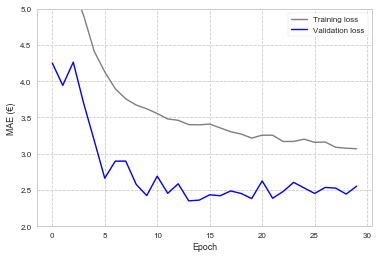

Checkpoint Ensembling

Training model # 2
Epoch 1/30
276/276 [==============================] - 637s 2s/step - loss: 1.1829 - mean_squared_error: 2.9106 - val_loss: 0.5637 - val_mean_squared_error: 0.5427
Epoch 2/30
276/276 [==============================] - 611s 2s/step - loss: 0.4865 - mean_squared_error: 0.5880 - val_loss: 0.3200 - val_mean_squared_error: 0.2167
Epoch 3/30
276/276 [==============================] - 610s 2s/step - loss: 0.3975 - mean_squared_error: 0.4188 - val_loss: 0.2975 - val_mean_squared_error: 0.1818
Epoch 4/30
276/276 [==============================] - 611s 2s/step - loss: 0.3590 - mean_squared_error: 0.3848 - val_loss: 0.2476 - val_mean_squared_error: 0.1319
Epoch 5/30
276/276 [==============================] - 609s 2s/step - loss: 0.3279 - mean_squared_error: 0.3255 - val_loss: 0.2472 - val_mean_squared_error: 0.1284
Epoch 6/30
276/276 [==============================] - 610s 2s/step - loss: 0.3156 - mean_squared_error: 0.3283 - val_loss: 0.2270 - val_mean_sq

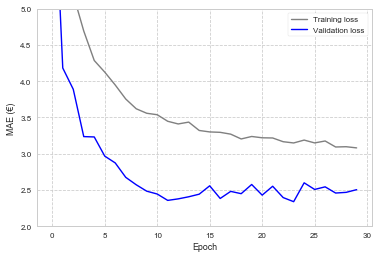

Checkpoint Ensembling

Training model # 3
Epoch 1/30
276/276 [==============================] - 698s 3s/step - loss: 1.1003 - mean_squared_error: 2.5315 - val_loss: 0.4827 - val_mean_squared_error: 0.4009
Epoch 2/30
276/276 [==============================] - 640s 2s/step - loss: 0.4710 - mean_squared_error: 0.5440 - val_loss: 0.3625 - val_mean_squared_error: 0.2499
Epoch 3/30
276/276 [==============================] - 638s 2s/step - loss: 0.3963 - mean_squared_error: 0.4244 - val_loss: 0.3057 - val_mean_squared_error: 0.1883
Epoch 4/30
276/276 [==============================] - 640s 2s/step - loss: 0.3631 - mean_squared_error: 0.3737 - val_loss: 0.2508 - val_mean_squared_error: 0.1347
Epoch 5/30
276/276 [==============================] - 638s 2s/step - loss: 0.3321 - mean_squared_error: 0.3177 - val_loss: 0.2589 - val_mean_squared_error: 0.1337
Epoch 6/30
276/276 [==============================] - 636s 2s/step - loss: 0.3092 - mean_squared_error: 0.2888 - val_loss: 0.2534 - val_mean_sq

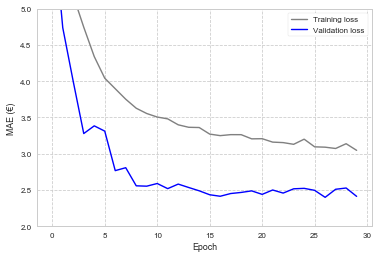

Checkpoint Ensembling

Training model # 4
Epoch 1/30
276/276 [==============================] - 748s 3s/step - loss: 1.2902 - mean_squared_error: 3.4398 - val_loss: 0.3381 - val_mean_squared_error: 0.2400
Epoch 2/30
276/276 [==============================] - 652s 2s/step - loss: 0.5100 - mean_squared_error: 0.6259 - val_loss: 0.3143 - val_mean_squared_error: 0.2081
Epoch 3/30
276/276 [==============================] - 653s 2s/step - loss: 0.4016 - mean_squared_error: 0.4254 - val_loss: 0.2912 - val_mean_squared_error: 0.1775
Epoch 4/30
276/276 [==============================] - 652s 2s/step - loss: 0.3614 - mean_squared_error: 0.3646 - val_loss: 0.2957 - val_mean_squared_error: 0.1721
Epoch 5/30
276/276 [==============================] - 649s 2s/step - loss: 0.3330 - mean_squared_error: 0.3193 - val_loss: 0.2222 - val_mean_squared_error: 0.1119
Epoch 6/30
276/276 [==============================] - 649s 2s/step - loss: 0.3172 - mean_squared_error: 0.3059 - val_loss: 0.2375 - val_mean_sq

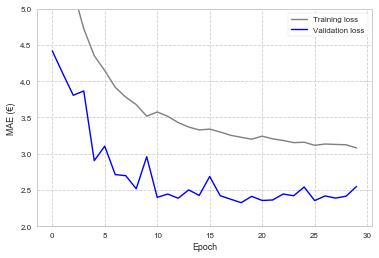

Checkpoint Ensembling

Training model # 5
Epoch 1/30
276/276 [==============================] - 776s 3s/step - loss: 1.3407 - mean_squared_error: 3.6986 - val_loss: 0.3733 - val_mean_squared_error: 0.2688
Epoch 2/30
276/276 [==============================] - 697s 3s/step - loss: 0.5130 - mean_squared_error: 0.5962 - val_loss: 0.3057 - val_mean_squared_error: 0.2006
Epoch 3/30
276/276 [==============================] - 682s 2s/step - loss: 0.4046 - mean_squared_error: 0.4050 - val_loss: 0.2687 - val_mean_squared_error: 0.1614
Epoch 4/30
276/276 [==============================] - 680s 2s/step - loss: 0.3707 - mean_squared_error: 0.3994 - val_loss: 0.2668 - val_mean_squared_error: 0.1518
Epoch 5/30
276/276 [==============================] - 677s 2s/step - loss: 0.3395 - mean_squared_error: 0.3251 - val_loss: 0.2703 - val_mean_squared_error: 0.1470
Epoch 6/30
276/276 [==============================] - 679s 2s/step - loss: 0.3236 - mean_squared_error: 0.3431 - val_loss: 0.2524 - val_mean_sq

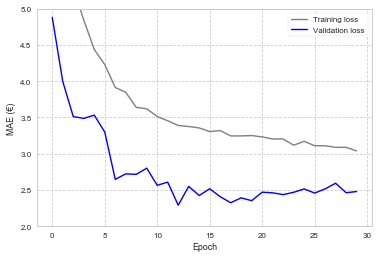

Checkpoint Ensembling


In [14]:
modelnum = 'Multi_1'
path = 'Results - Final/Multi_1/'

market_x = layers.Input(shape = (lookback_market+1, market_train.shape[-1]))
grib_x = layers.Input(shape = (lookback_grib+1, grib_train.shape[1], grib_train.shape[2], grib_train.shape[3]))

results_1 = evaluate_mlp(multi_1, market_x, grib_x, train_gen, train_steps, stdev, val_gen, val_steps, test_gen, test_steps,
                         path, k = 5, epochs = 30, ce_k = 5)

In [15]:
# Print the 10 best epochs for each model so we can manually delete the other weights
for i in range(5):
    print(results_1["val_ranked_epochs"][i][0:10])

[14 15 20 22 17 10 16 29 19 26]
[24 12 13 17 23 14 21 15 11 19]
[27 30 17 16 21 18 23 19 20 15]
[19 26 21 22 18 13 28 11 20 29]
[13 18 20 19 17 15 23 26 22 29]


In [16]:
batch_size = 128
lookback_market = 21*24
lookback_grib = 6

val_gen = multi_generator(market_valid, grib_valid, vwp_valid, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)
test_gen = multi_generator(market_test, grib_test, vwp_test, lookback_market = lookback_market, lookback_grib = lookback_grib, batch_size = batch_size)

lookback_max = max(lookback_market, lookback_grib)

val_steps = (valid_size - lookback_max) // batch_size
test_steps = (test_size - lookback_max) // batch_size

path = 'Results - Final/Multi_1/'
market_x = layers.Input(shape = (lookback_market+1, market_train.shape[-1]))
grib_x = layers.Input(shape = (lookback_grib+1, grib_train.shape[1], grib_train.shape[2], grib_train.shape[3]))

evaluate_results(multi_1, path)

VALIDATION
+-------+--------------+---------------+------------+-------------+
| Model | Min. MAE (€) | Ass. RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+--------------+---------------+------------+-------------+
|   1   |    2.3498    |     3.5415    |   2.3031   |    3.4525   |
|   2   |    2.3383    |     3.4533    |   2.2854   |    3.4003   |
|   3   |    2.3984    |     3.5398    |   2.3277   |    3.5034   |
|   4   |    2.3246    |     3.4578    |   2.2688   |    3.3844   |
|   5   |    2.2898    |     3.5277    |   2.2842   |    3.4897   |
+-------+--------------+---------------+------------+-------------+
Ensembling across
MAE  (€): 2.2482
RMSE (€): 3.3856

TEST
+-------+----------+-----------+------------+-------------+
| Model |  MAE (€) |  RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+----------+-----------+------------+-------------+
|   1   |  2.7740  |   4.3489  |   2.7359   |    4.3236   |
|   2   |  2.8253  |   4.3390  |   2.7241   |    4.2574   |
|   3   |  2.8569  